# Keras Model ensemble

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [2]:
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

In [3]:
df = pd.DataFrame(data.data)

In [4]:
df.columns = feature_names

- data normalization

In [5]:
low_quantiles = df.quantile(0.01)
high_quantiles = df.quantile(0.99)

outliers_low = (df < low_quantiles)
outliers_high = (df > high_quantiles)

df = df.mask(outliers_low, low_quantiles, axis=1)
df = df.mask(outliers_high, high_quantiles, axis=1)

df = (df - np.min(df, axis=0)) / (np.max(df, axis=0) - np.min(df, axis=0))
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.598975,0.000000,0.616395,0.499916,0.774450,1.000000,0.853313,0.895815,0.864182,0.801742,...,0.750278,0.080040,0.842009,0.662220,0.735559,0.844837,0.788914,0.985826,0.913767,0.735181
1,0.761105,0.346808,0.706657,0.706799,0.250428,0.185732,0.247094,0.427324,0.397460,0.152238,...,0.732185,0.308598,0.670047,0.638553,0.355354,0.187366,0.267736,0.690895,0.318361,0.371005
2,0.705805,0.523264,0.680740,0.628502,0.637451,0.518982,0.561293,0.778890,0.595067,0.250077,...,0.666308,0.388292,0.628057,0.545765,0.559318,0.513905,0.499125,0.902621,0.595960,0.353455
3,0.186112,0.479150,0.212271,0.108493,1.000000,1.000000,0.686404,0.640651,1.000000,1.000000,...,0.264549,0.424756,0.270603,0.117022,1.000000,1.000000,0.761209,0.956481,1.000000,1.000000
4,0.743509,0.172887,0.726318,0.688339,0.492667,0.407844,0.562999,0.635170,0.395153,0.215892,...,0.618524,0.055230,0.626057,0.495426,0.490010,0.212622,0.443272,0.603605,0.194197,0.221825


In [6]:
df = pd.concat([df,pd.DataFrame(target)],axis = 1)

In [7]:
X_var = feature_names

In [8]:
colnames = list(feature_names)
colnames.append('target')

In [9]:
df.columns = colnames

In [11]:
df.target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df[X_var]), target, test_size=0.2, random_state=42)

In [14]:
import math
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Average
from keras.models import Model, Input
from keras import objectives, backend as K
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard

from keras.engine.input_layer import Input

Using TensorFlow backend.


In [18]:
def makeModel(input_x, numOfOut, z_dim,m_name):    
    x = Dense(z_dim*2,activation='relu')(input_x)
    x = Dropout(0.3)(x)
    x = Dense(z_dim, activation='relu')(x)
    out = Dense(numOfOut, activation='softmax')(x)
    
    model = Model(input_x,out, name= m_name)
    return model

In [19]:
z_dim = 20
input_dim = X_train.shape[1]
input_x = Input(shape = (input_dim,))

model = makeModel(input_x = input_x, numOfOut=len(np.unique(target)), z_dim=z_dim, m_name = 'model1')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 42        
Total params: 2,102
Trainable params: 2,102
Non-trainable params: 0
_________________________________________________________________


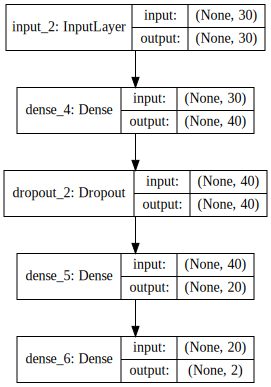

In [20]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [21]:
K.clear_session()

In [23]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [24]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_en = encoder.transform(y_train)
y_train_en = keras.utils.to_categorical(y_train_en, num_classes=len(set(encoder.classes_)))

encoder = LabelEncoder()
encoder.fit(y_test)

Y_VAL_CLS = encoder.transform(y_test)
Y_VAL_CLS = keras.utils.to_categorical(Y_VAL_CLS, num_classes=len(set(encoder.classes_)))

print(Y_VAL_CLS.shape)
print(encoder.classes_)

(114, 2)
[0 1]


In [25]:
def compile_and_train(model, num_epochs,m_name): 
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','mae'])
    filepath = 'models/' + str(m_name) + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_weights_only=True,
                                                 save_best_only=True, mode='auto', period=1)
#     tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=32)
    earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
#     history = model.fit(x=X_train, y=y_train_en, batch_size=50,epochs=num_epochs, 
#                         verbose=1, callbacks=[checkpoint,earlyStopping], validation_data=(X_test, Y_VAL_CLS),  validation_split=0.2)
    history = model.fit(x=X_train, y=y_train_en, batch_size=50,epochs=num_epochs, 
                    verbose=1, callbacks=[checkpoint],  validation_split=0.2)
    return history

In [26]:
z_dim = 20
input_dim = X_train.shape[1]
input_x = Input(shape = (input_dim,))

In [28]:
from IPython.display import clear_output

In [29]:
hist = []
for i in range(1,6):
    model = makeModel(input_x =input_x, numOfOut=len(np.unique(target)), z_dim=z_dim,m_name = 'model'+str(i))
    hist.append(compile_and_train(model,20,'model'+str(i)))
    clear_output()

In [33]:
for hist_o in hist:
    print("model acc :", hist_o.history['acc'][-1])

model acc : 0.9340659314459496
model acc : 0.9203296726221567
model acc : 0.9258241679642226
model acc : 0.9313186845936618
model acc : 0.9368131766607474


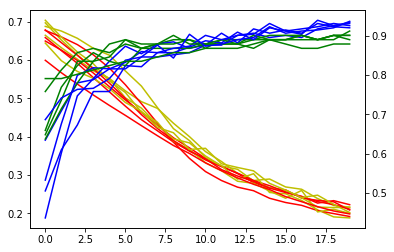

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

for hist_o in hist:
    loss_ax.plot(hist_o.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist_o.history['val_loss'], 'r', label='val loss')

    acc_ax.plot(hist_o.history['acc'], 'b', label='train acc')
    acc_ax.plot(hist_o.history['val_acc'], 'g', label='val acc')


# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

In [35]:
K.clear_session()
z_dim = 20
input_dim = X_train.shape[1]
input_x = Input(shape = (input_dim,))
models = []
for i in range(1,6):
    model =makeModel(input_x = input_x, numOfOut=len(np.unique(target)), z_dim=z_dim,m_name = 'model'+str(i))
    model.load_weights("models/model"+str(i)+".hdf5")
    print(model.name)
    models.append(model)

model1
model2
model3
model4
model5


In [36]:
def evaluate_error(model):
    pred = model.predict(X_test, batch_size = 32)
    pred = np.argmax(pred, axis=1)
    pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    error = np.sum(np.not_equal(pred, y_test)) / y_test.shape[0]    
    return error

In [37]:
for model_o in models:
    print(model_o.name,evaluate_error(model_o))

model1 53.80701754385965
model2 53.07017543859649
model3 53.07017543859649
model4 52.578947368421055
model5 52.824561403508774


In [38]:
for model_o in models:
    print(model_o.name)
    print("Train acc :",1-sum(model_o.predict(X_train).argmax(axis=1) != y_train_en.argmax(axis=1)) / y_train_en.shape[0])
    print("Test acc :",1-sum(model_o.predict(X_test).argmax(axis=1) != Y_VAL_CLS.argmax(axis=1)) / Y_VAL_CLS.shape[0])

model1
Train acc : 0.9252747252747253
Test acc : 0.956140350877193
model2
Train acc : 0.9494505494505494
Test acc : 0.9649122807017544
model3
Train acc : 0.9406593406593406
Test acc : 0.9649122807017544
model4
Train acc : 0.9516483516483516
Test acc : 0.9649122807017544
model5
Train acc : 0.9516483516483516
Test acc : 0.9736842105263158


In [39]:
def ensemble(models, model_input):
    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

In [40]:
ensemble_model = ensemble(models,input_x)

In [41]:
evaluate_error(ensemble_model)

53.07017543859649

In [42]:
print(ensemble_model.name)
print("Train acc :",1-sum(ensemble_model.predict(X_train).argmax(axis=1) != y_train_en.argmax(axis=1)) / y_train_en.shape[0])
print("Test acc :",1-sum(ensemble_model.predict(X_test).argmax(axis=1) != Y_VAL_CLS.argmax(axis=1)) / Y_VAL_CLS.shape[0])

ensemble
Train acc : 0.9472527472527472
Test acc : 0.9649122807017544
